In [4]:
# --- Импорты ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_squared_error, r2_score,
    silhouette_score, adjusted_rand_score
)
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Фиксация случайности
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print("✅ Окружение подготовлено")

✅ Окружение подготовлено



1. ЗАГРУЗКА И АНАЛИЗ ДАННЫХ CIFAR-10
Загрузка CIFAR-10...
Размер обучающей выборки: 50000
Размер тестовой выборки: 10000
Классы: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Форма батча изображений: torch.Size([4, 3, 32, 32])
Метки батча: tensor([8, 4, 2, 7])
Значения пикселей в диапазоне: [-1.000, 0.953]


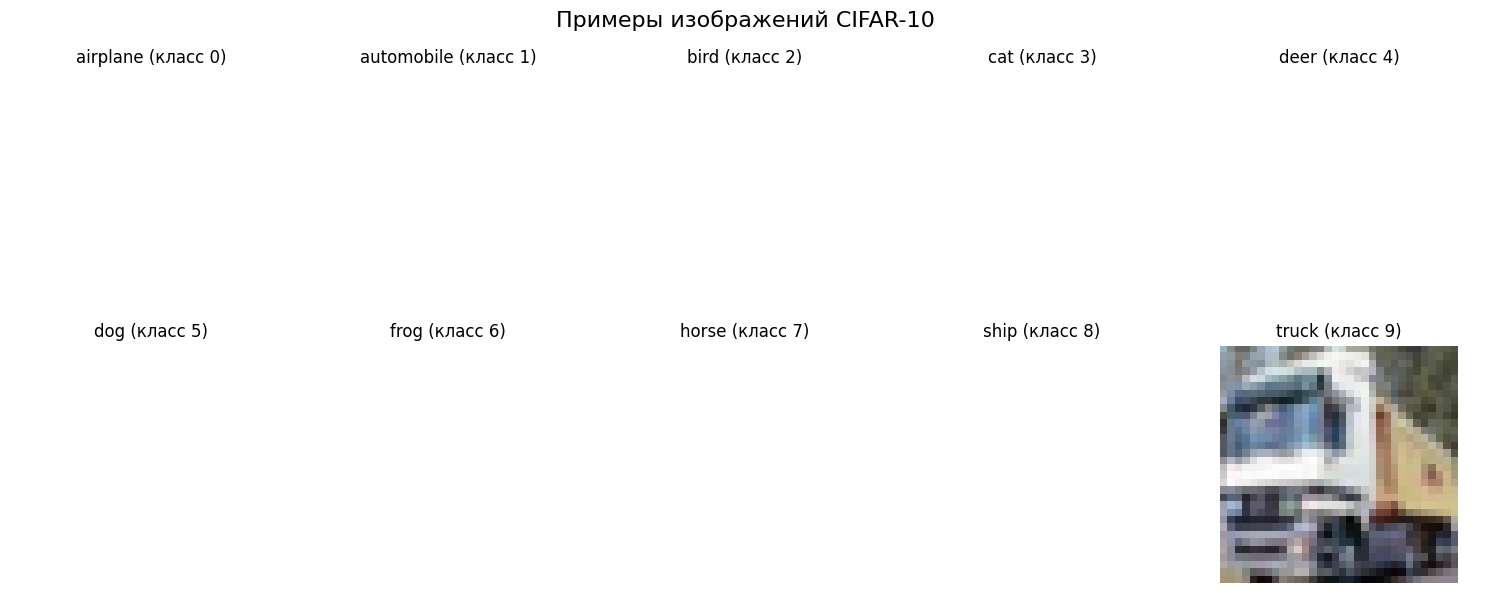

In [16]:
# ============================================================
# 1. ЗАГРУЗКА И ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ CIFAR-10
# ============================================================
print("\n" + "="*60)
print("1. ЗАГРУЗКА И АНАЛИЗ ДАННЫХ CIFAR-10")
print("="*60)

# Определение трансформаций
transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразует PIL Image или numpy.ndarray в тензор
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация
])

# Загрузка данных
print("Загрузка CIFAR-10...")
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Классы CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Размер обучающей выборки: {len(trainset)}")
print(f"Размер тестовой выборки: {len(testset)}")
print(f"Классы: {class_names}")

# Загрузка одного батча для проверки
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

dataiter = iter(trainloader)
images, labels = next(dataiter)

print(f"\nФорма батча изображений: {images.shape}")  # (batch_size, channels, height, width)
print(f"Метки батча: {labels}")
print(f"Значения пикселей в диапазоне: [{images.min():.3f}, {images.max():.3f}]")

# Визуализация примеров изображений
def imshow(img):
    """Функция для отображения изображения"""
    img = img / 2 + 0.5  # Денормализация: обратная операция Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Примеры изображений CIFAR-10', fontsize=16)

# Берем по одному примеру каждого класса
class_examples = {i: None for i in range(10)}
for i in range(len(trainset)):
    img, label = trainset[i]
    if class_examples[label] is None:
        class_examples[label] = (img, label)
    if all(v is not None for v in class_examples.values()):
        break

for i, ax in enumerate(axes.flat):
    img, label = class_examples[i]
    imshow(img)
    ax.set_title(f'{class_names[label]} (класс {label})')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# ============================================================
# 2. ПОДГОТОВКА ДАННЫХ ДЛЯ АНАЛИЗА
# ============================================================
print("\n" + "="*60)
print("2. ПОДГОТОВКА ДАННЫХ ДЛЯ АНАЛИЗА")
print("="*60)

# Для ускорения обработки возьмем подмножество данных (можно увеличить при наличии ресурсов)
SUBSET_SIZE = 10000  # Размер подмножества для анализа

# Создаем индексы для подмножества
train_indices = np.random.choice(len(trainset), SUBSET_SIZE, replace=False)
test_indices = np.random.choice(len(testset), min(2000, len(testset)), replace=False)

# Создаем подмножества
train_subset = Subset(trainset, train_indices)
test_subset = Subset(testset, test_indices)

# Преобразуем в numpy массивы
def extract_data(subset):
    """Извлекает данные и метки из подмножества"""
    images_list = []
    labels_list = []
    
    for img, label in subset:
        # Преобразуем тензор в numpy массив и выравниваем
        img_np = img.numpy().reshape(-1)  # (3072,) - 3*32*32=3072
        images_list.append(img_np)
        labels_list.append(label)
    
    return np.array(images_list), np.array(labels_list)

print("Извлечение данных из подмножеств...")
X_train_full, y_train_full = extract_data(train_subset)
X_test_full, y_test_full = extract_data(test_subset)

print(f"Размер обучающего подмножества: {X_train_full.shape}")
print(f"Размер тестового подмножества: {X_test_full.shape}")

# Проверка баланса классов в подмножестве
unique, counts = np.unique(y_train_full, return_counts=True)
print("\nБаланс классов в обучающем подмножестве:")
for cls, cnt in zip(unique, counts):
    print(f"  Класс {class_names[cls]}: {cnt} образцов ({cnt/len(y_train_full)*100:.1f}%)")

# Разделение на train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=SEED, stratify=y_train_full
)

print(f"\nОбучающая выборка: {X_train.shape[0]} образцов")
print(f"Валидационная выборка: {X_val.shape[0]} образцов")
print(f"Тестовая выборка: {X_test_full.shape[0]} образцов")

# Создание DataLoader для нейронной сети (используем оригинальные данные для сохранения структуры)
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test_full), torch.LongTensor(y_test_full))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nРазмер батча: {batch_size}")
print(f"Количество батчей в train: {len(train_loader)}")


2. ПОДГОТОВКА ДАННЫХ ДЛЯ АНАЛИЗА
Извлечение данных из подмножеств...
Размер обучающего подмножества: (10000, 3072)
Размер тестового подмножества: (2000, 3072)

Баланс классов в обучающем подмножестве:
  Класс airplane: 973 образцов (9.7%)
  Класс automobile: 979 образцов (9.8%)
  Класс bird: 1030 образцов (10.3%)
  Класс cat: 1023 образцов (10.2%)
  Класс deer: 933 образцов (9.3%)
  Класс dog: 1015 образцов (10.2%)
  Класс frog: 996 образцов (10.0%)
  Класс horse: 994 образцов (9.9%)
  Класс ship: 1017 образцов (10.2%)
  Класс truck: 1040 образцов (10.4%)

Обучающая выборка: 8000 образцов
Валидационная выборка: 2000 образцов
Тестовая выборка: 2000 образцов

Размер батча: 64
Количество батчей в train: 125



3. КЛАСТЕРИЗАЦИЯ И АНАЛИЗ СТРУКТУРЫ ДАННЫХ
Применение PCA для уменьшения размерности...


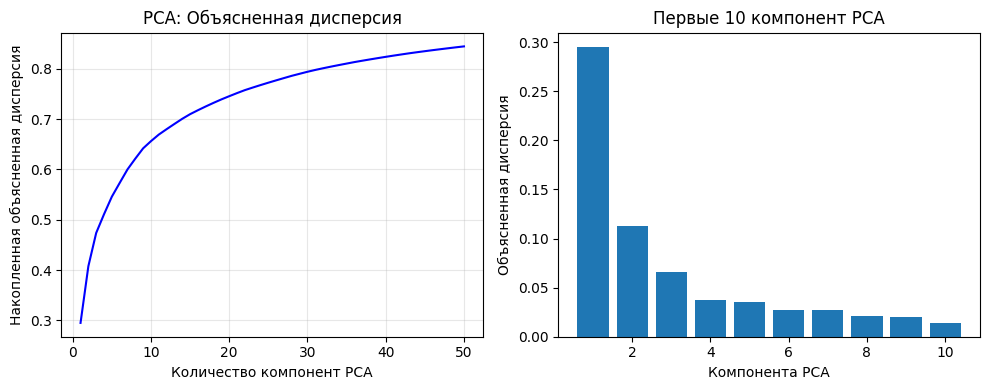

Первые 10 компонент объясняют 65.6% дисперсии
Все 50 компонент объясняют 84.5% дисперсии

Поиск оптимального числа кластеров методом локтя...


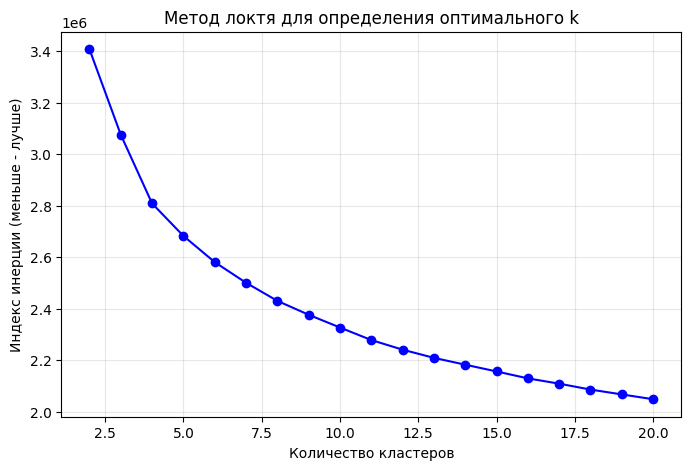

Применение t-SNE для визуализации...


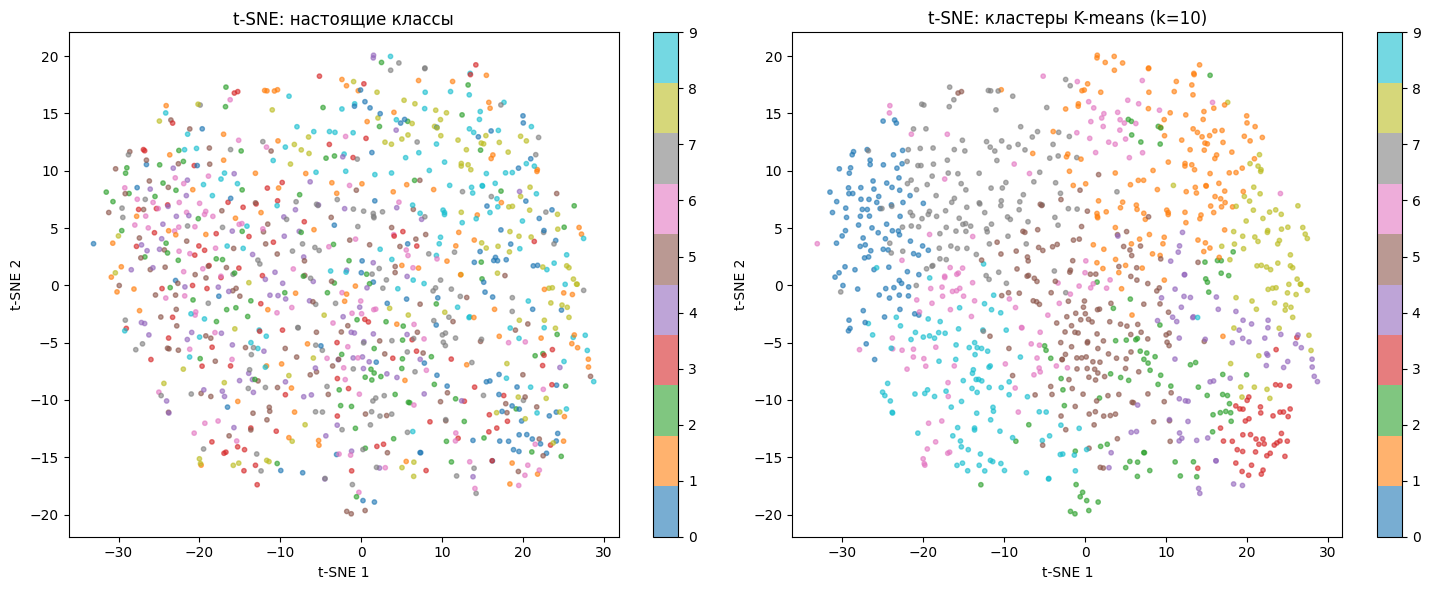


Метрики качества кластеризации K-means:
  Silhouette Score: 0.0704
  Adjusted Rand Index: 0.0403


In [8]:
# ============================================================
# 3. КЛАСТЕРИЗАЦИЯ И АНАЛИЗ СТРУКТУРЫ ДАННЫХ
# ============================================================
print("\n" + "="*60)
print("3. КЛАСТЕРИЗАЦИЯ И АНАЛИЗ СТРУКТУРЫ ДАННЫХ")
print("="*60)

# Уменьшение размерности для визуализации и кластеризации
print("Применение PCA для уменьшения размерности...")
pca = PCA(n_components=50, random_state=SEED)
X_pca = pca.fit_transform(X_train)

# Объясненная дисперсия
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 51), explained_variance, 'b-')
plt.xlabel('Количество компонент PCA')
plt.ylabel('Накопленная объясненная дисперсия')
plt.title('PCA: Объясненная дисперсия')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(1, 11), pca.explained_variance_ratio_[:10])
plt.xlabel('Компонента PCA')
plt.ylabel('Объясненная дисперсия')
plt.title('Первые 10 компонент PCA')
plt.tight_layout()
plt.show()

print(f"Первые 10 компонент объясняют {explained_variance[9]*100:.1f}% дисперсии")
print(f"Все 50 компонент объясняют {explained_variance[-1]*100:.1f}% дисперсии")

# Метод локтя для определения оптимального числа кластеров
print("\nПоиск оптимального числа кластеров методом локтя...")
inertia = []
k_range = range(2, 21)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    kmeans.fit(X_pca[:, :20])  # Используем первые 20 компонент для скорости
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Индекс инерции (меньше - лучше)')
plt.title('Метод локтя для определения оптимального k')
plt.grid(True, alpha=0.3)
plt.show()

# Кластеризация K-means с оптимальным k (выбираем 10, так как у нас 10 классов)
kmeans = KMeans(n_clusters=10, random_state=SEED, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_pca[:, :50])

# t-SNE для визуализации кластеров
print("Применение t-SNE для визуализации...")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca[:1000])  # Берем подмножество для скорости

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Визуализация настоящих классов
scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                          c=y_train[:1000], cmap='tab10', s=10, alpha=0.6)
axes[0].set_title('t-SNE: настоящие классы')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
plt.colorbar(scatter1, ax=axes[0])

# Визуализация кластеров K-means
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                          c=clusters_kmeans[:1000], cmap='tab10', s=10, alpha=0.6)
axes[1].set_title('t-SNE: кластеры K-means (k=10)')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()

# Оценка качества кластеризации
silhouette_kmeans = silhouette_score(X_pca[:, :50], clusters_kmeans)
ari_kmeans = adjusted_rand_score(y_train, clusters_kmeans)

print("\nМетрики качества кластеризации K-means:")
print(f"  Silhouette Score: {silhouette_kmeans:.4f}")
print(f"  Adjusted Rand Index: {ari_kmeans:.4f}")


4. КЛАССИЧЕСКИЕ МОДЕЛИ МАШИННОГО ОБУЧЕНИЯ

Обучение Logistic Regression...
  Train Accuracy: 0.3899
  Val Accuracy: 0.3775
  Val F1-Score: 0.3730

Обучение Random Forest...
  Train Accuracy: 1.0000
  Val Accuracy: 0.4090
  Val F1-Score: 0.4051

Обучение SVM (RBF)...
  Train Accuracy: 0.6216
  Val Accuracy: 0.4610
  Val F1-Score: 0.4572

Обучение KNN (k=5)...
  Train Accuracy: 0.5209
  Val Accuracy: 0.3370
  Val F1-Score: 0.3313

Обучение Gradient Boosting...
  Train Accuracy: 0.6950
  Val Accuracy: 0.4045
  Val F1-Score: 0.4000

СРАВНЕНИЕ КЛАССИЧЕСКИХ МОДЕЛЕЙ:
                    train_accuracy val_accuracy    val_f1
SVM (RBF)                 0.621625        0.461    0.4572
Random Forest                  1.0        0.409  0.405133
Gradient Boosting            0.695       0.4045  0.399995
Logistic Regression       0.389875       0.3775   0.37304
KNN (k=5)                 0.520875        0.337  0.331341


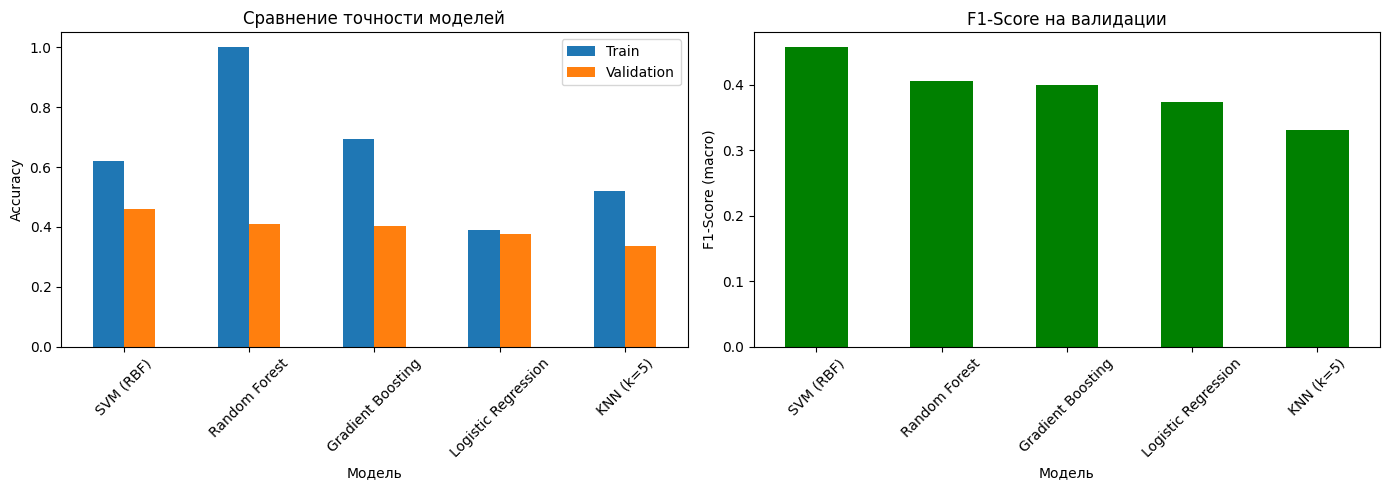


Лучшая классическая модель: SVM (RBF)


In [9]:
# ============================================================
# 4. КЛАССИЧЕСКИЕ МОДЕЛИ МАШИННОГО ОБУЧЕНИЯ
# ============================================================
print("\n" + "="*60)
print("4. КЛАССИЧЕСКИЕ МОДЕЛИ МАШИННОГО ОБУЧЕНИЯ")
print("="*60)

# Для классических моделей используем PCA-признаки
X_train_classic = X_pca[:, :100]  # 100 главных компонент
X_val_pca = pca.transform(X_val)[:, :100]
X_test_pca = pca.transform(X_test_full)[:, :100]

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=SEED, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1),
    'SVM (RBF)': SVC(kernel='rbf', random_state=SEED, probability=True),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=SEED)
}

results = {}

for name, model in models.items():
    print(f"\nОбучение {name}...")
    model.fit(X_train_classic, y_train)
    
    # Предсказания
    y_train_pred = model.predict(X_train_classic)
    y_val_pred = model.predict(X_val_pca)
    
    # Метрики
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    
    results[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'val_f1': val_f1
    }
    
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Val Accuracy: {val_acc:.4f}")
    print(f"  Val F1-Score: {val_f1:.4f}")

# Сравнение моделей
results_df = pd.DataFrame(results).T
results_df = results_df[['train_accuracy', 'val_accuracy', 'val_f1']]
results_df = results_df.sort_values('val_accuracy', ascending=False)

print("\n" + "="*60)
print("СРАВНЕНИЕ КЛАССИЧЕСКИХ МОДЕЛЕЙ:")
print("="*60)
print(results_df)

# Визуализация сравнения моделей
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy сравнение
results_df[['train_accuracy', 'val_accuracy']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Сравнение точности моделей')
axes[0].set_xlabel('Модель')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'])
axes[0].tick_params(axis='x', rotation=45)

# F1-score сравнение
results_df['val_f1'].plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title('F1-Score на валидации')
axes[1].set_xlabel('Модель')
axes[1].set_ylabel('F1-Score (macro)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Лучшая классическая модель
best_classic_name = results_df.index[0]
best_classic_model = results[best_classic_name]['model']
print(f"\nЛучшая классическая модель: {best_classic_name}")


5. НЕЙРОННАЯ СЕТЬ (CNN) ДЛЯ CIFAR-10
Используемое устройство: cuda
Модель: CIFAR10CNN
Функция потерь: CrossEntropyLoss
Оптимизатор: Adam
Параметров модели: 1,048,074

Начинаем обучение на 20 эпох...
------------------------------------------------------------
Эпоха  1/20 | Train Loss: 1.8111, Train Acc: 30.00% | Val Loss: 1.6589, Val Acc: 40.40%
Эпоха  5/20 | Train Loss: 1.0415, Train Acc: 63.24% | Val Loss: 1.0710, Val Acc: 63.20%
Эпоха 10/20 | Train Loss: 0.5672, Train Acc: 79.41% | Val Loss: 1.0034, Val Acc: 67.80%
Эпоха 15/20 | Train Loss: 0.2902, Train Acc: 90.14% | Val Loss: 1.5109, Val Acc: 63.55%
Эпоха 20/20 | Train Loss: 0.1428, Train Acc: 95.30% | Val Loss: 1.8937, Val Acc: 64.35%

Лучшая точность на валидации: 67.90%


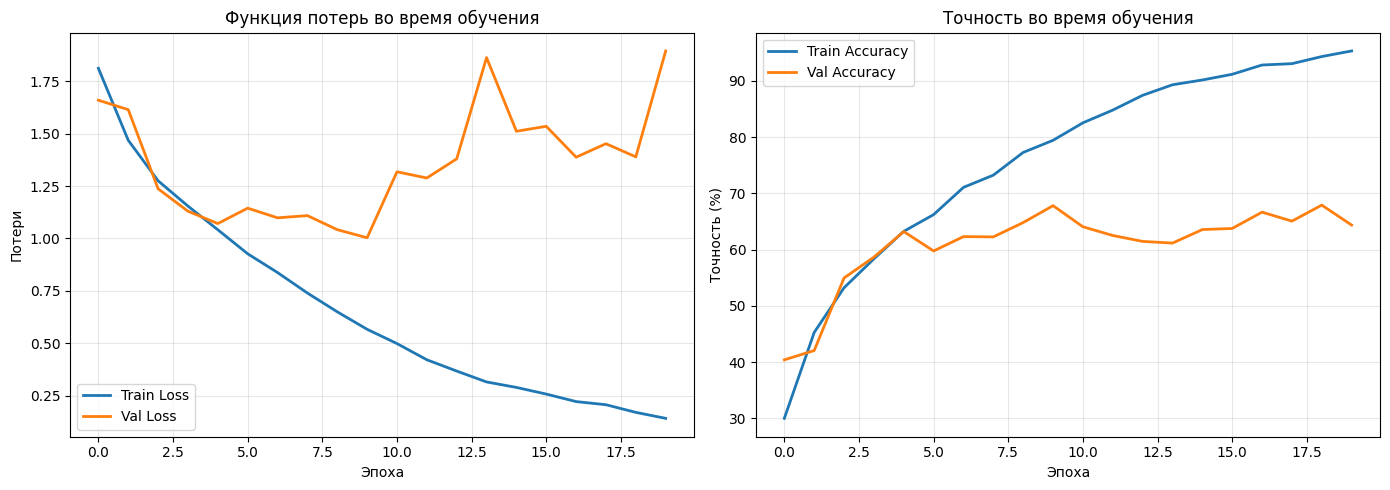

In [10]:
# ============================================================
# 5. НЕЙРОННАЯ СЕТЬ (CNN) ДЛЯ CIFAR-10
# ============================================================
print("\n" + "="*60)
print("5. НЕЙРОННАЯ СЕТЬ (CNN) ДЛЯ CIFAR-10")
print("="*60)

# Определение архитектуры CNN для CIFAR-10
class CIFAR10CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFAR10CNN, self).__init__()
        
        # Сверточные слои
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Полносвязные слои
        self.fc1 = nn.Linear(256 * 2 * 2, 512)  # После 4 пулингов 32x32 -> 2x2
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, num_classes)
        
        # Пулинг
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        # Конволюции с активациями и пулингом
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Выравнивание
        x = x.view(-1, 256 * 2 * 2)
        
        # Полносвязные слои
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

# Инициализация модели, функции потерь и оптимизатора
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

model = CIFAR10CNN(num_classes=10).to(device)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

print(f"Модель: {model.__class__.__name__}")
print(f"Функция потерь: {criterion.__class__.__name__}")
print(f"Оптимизатор: {optimizer.__class__.__name__}")
print(f"Параметров модели: {sum(p.numel() for p in model.parameters()):,}")

# Функции для обучения и валидации
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(loader):
        # Изменяем форму данных для CNN: (batch_size, 3072) -> (batch_size, 3, 32, 32)
        data = data.view(-1, 3, 32, 32).to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in loader:
            data = data.view(-1, 3, 32, 32).to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

# Обучение с контролем переобучения
epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0
best_model_state = None

print(f"\nНачинаем обучение на {epochs} эпох...")
print("-" * 60)

for epoch in range(epochs):
    # Обучение
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Валидация
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Сохранение метрик
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
    
    # Вывод прогресса
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Эпоха {epoch+1:2d}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Загрузка лучшей модели
if best_model_state is not None:
    model.load_state_dict(best_model_state)

print(f"\nЛучшая точность на валидации: {best_val_acc:.2f}%")

# Графики обучения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График потерь
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Потери')
axes[0].set_title('Функция потерь во время обучения')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График точности
axes[1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[1].plot(val_accs, label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Точность (%)')
axes[1].set_title('Точность во время обучения')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


6. ОЦЕНКА И ГЕНЕРАЛИЗАЦИЯ МОДЕЛИ

Тестовая точность: 62.80%
Тестовые потери: 2.0308

Базовый уровень (случайное угадывание): 10.0%
Улучшение относительно базового уровня: 52.8%

Детальные метрики на тестовой выборке:
  Accuracy: 0.6280
  Precision (macro): 0.6818
  Recall (macro): 0.6274
  F1-Score (macro): 0.6280


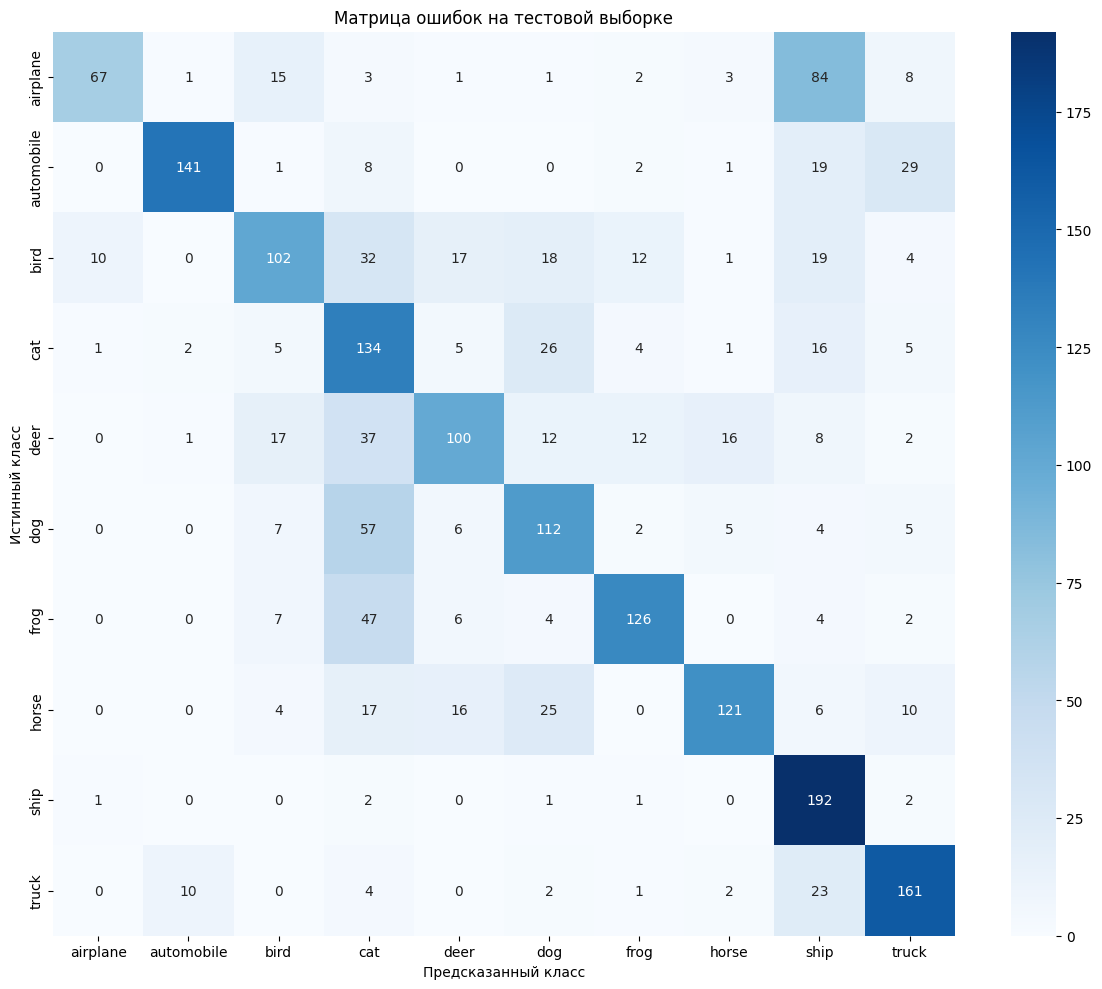


Отчет по классификации:
              precision    recall  f1-score   support

    airplane       0.85      0.36      0.51       185
  automobile       0.91      0.70      0.79       201
        bird       0.65      0.47      0.55       215
         cat       0.39      0.67      0.50       199
        deer       0.66      0.49      0.56       205
         dog       0.56      0.57      0.56       198
        frog       0.78      0.64      0.70       196
       horse       0.81      0.61      0.69       199
        ship       0.51      0.96      0.67       199
       truck       0.71      0.79      0.75       203

    accuracy                           0.63      2000
   macro avg       0.68      0.63      0.63      2000
weighted avg       0.68      0.63      0.63      2000


Анализ ошибок по классам:
     class  total  errors  error_rate
  airplane      0       0           0
automobile      0       0           0
      bird      0       0           0
       cat      0       0           0

In [11]:
# ============================================================
# 6. ОЦЕНКА И ГЕНЕРАЛИЗАЦИЯ МОДЕЛИ
# ============================================================
print("\n" + "="*60)
print("6. ОЦЕНКА И ГЕНЕРАЛИЗАЦИЯ МОДЕЛИ")
print("="*60)

# Финальная оценка на тестовой выборке
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f"\nТестовая точность: {test_acc:.2f}%")
print(f"Тестовые потери: {test_loss:.4f}")

# Сравнение с базовой моделью (случайное угадывание)
baseline_acc = 100.0 / 10  # 10 классов
print(f"\nБазовый уровень (случайное угадывание): {baseline_acc:.1f}%")
print(f"Улучшение относительно базового уровня: {test_acc - baseline_acc:.1f}%")

# Подробные метрики на тестовой выборке
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.view(-1, 3, 32, 32).to(device)
        target = target.to(device)
        output = model(data)
        _, predicted = output.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Метрики классификации
test_accuracy = accuracy_score(all_targets, all_preds)
test_precision = precision_score(all_targets, all_preds, average='macro')
test_recall = recall_score(all_targets, all_preds, average='macro')
test_f1 = f1_score(all_targets, all_preds, average='macro')

print("\nДетальные метрики на тестовой выборке:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  Precision (macro): {test_precision:.4f}")
print(f"  Recall (macro): {test_recall:.4f}")
print(f"  F1-Score (macro): {test_f1:.4f}")

# Матрица ошибок
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Матрица ошибок на тестовой выборке')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.tight_layout()
plt.show()

# Отчет по классификации
print("\nОтчет по классификации:")
print(classification_report(all_targets, all_preds, target_names=class_names))

# Анализ ошибок
errors_by_class = []
for i in range(10):
    total = np.sum(all_targets == i)
    correct = np.sum((all_targets == i) & (all_preds == i))
    errors = total - correct
    errors_by_class.append({
        'class': class_names[i],
        'total': total,
        'correct': correct,
        'errors': errors,
        'error_rate': errors/total if total > 0 else 0
    })

errors_df = pd.DataFrame(errors_by_class)
errors_df = errors_df.sort_values('error_rate', ascending=False)

print("\nАнализ ошибок по классам:")
print(errors_df[['class', 'total', 'errors', 'error_rate']].to_string(index=False))


7. РЕГРЕССИОННЫЙ АНАЛИЗ
Вычисление сложности изображений...

Обучение моделей регрессии...

Ridge Regression:
  Train MSE: 0.020889, Test MSE: 0.020369
  Train R²: 0.0680, Test R²: 0.0784

Lasso Regression:
  Train MSE: 0.021039, Test MSE: 0.020577
  Train R²: 0.0613, Test R²: 0.0690

ElasticNet:
  Train MSE: 0.020936, Test MSE: 0.020444
  Train R²: 0.0659, Test R²: 0.0750

Random Forest Regressor:
  Train MSE: 0.001038, Test MSE: 0.007631
  Train R²: 0.9537, Test R²: 0.6547

Gradient Boosting Regressor:
  Train MSE: 0.007007, Test MSE: 0.008395
  Train R²: 0.6873, Test R²: 0.6202

СРАВНЕНИЕ МОДЕЛЕЙ РЕГРЕССИИ:
                             train_mse  test_mse  train_r2   test_r2
Random Forest Regressor       0.001038  0.007631  0.953706  0.654749
Gradient Boosting Regressor   0.007007  0.008395  0.687344  0.620186
Ridge Regression              0.020889  0.020369  0.067969  0.078403
ElasticNet                    0.020936  0.020444  0.065875  0.075022
Lasso Regression              0.0210

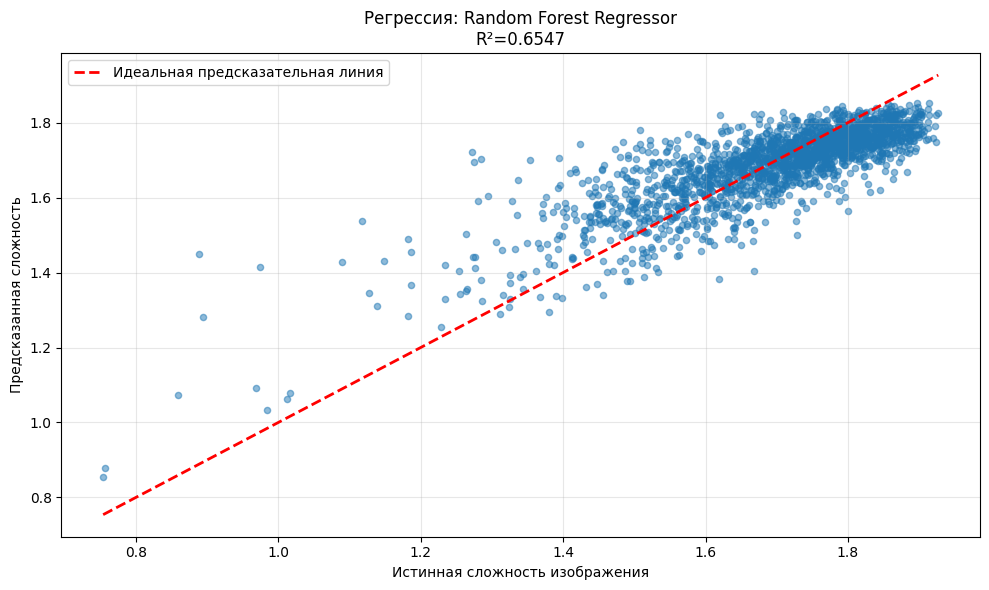

In [ ]:
# ============================================================
# 7. РЕГРЕССИОННЫЙ АНАЛИЗ (дополнительная задача)
# ============================================================
print("\n" + "="*60)
print("7. РЕГРЕССИОННЫЙ АНАЛИЗ")
print("="*60)

# Создаем искусственную регрессионную задачу:
# Предсказание "сложности" изображения на основе его признаков
def calculate_image_complexity(images):
    """Вычисление сложности изображения как целевой переменной для регрессии"""
    complexities = []
    for img in images:
        # Преобразуем из выровненного вида обратно в (3, 32, 32)
        img_reshaped = img.reshape(3, 32, 32)
        # Средняя интенсивность (учитывая, что данные нормализованы, вернем к [0,1])
        img_normalized = (img_reshaped + 1) / 2  # Обратная нормализация
        mean_intensity = np.mean(img_normalized)
        # Измеряет общую яркость изображения (20%)
        # Пример: Темное изображение => низкая интенсивность; светлое => высокая

        # Вариация (стандартное отклонение)
        variation = np.std(img_normalized)
        # Измеряет разброс значений пикселей, контрастность (50%)
        # Пример: Однотонное небо => низкая вариация; пестрый узор => высокая

        # Энтропия (мера сложности)
        histogram, _ = np.histogram(img_normalized.flatten(), bins=50, range=(0, 1))
        histogram = histogram / histogram.sum()
        entropy = -np.sum(histogram * np.log2(histogram + 1e-10))
        # Информационную насыщенность, разнообразие текстур (30%)
        # Пример: Простая геометрическая фигура => низкая энтропия; сложная текстура => высокая

        # Комбинированная мера сложности
        complexity = 0.2 * mean_intensity + 0.5 * variation + 0.3 * entropy
        complexities.append(complexity)
    return np.array(complexities)

# Целевая переменная для регрессии
print("Вычисление сложности изображений...")
y_reg_train = calculate_image_complexity(X_train)
y_reg_val = calculate_image_complexity(X_val)
y_reg_test = calculate_image_complexity(X_test_full)

# Признаки для регрессии (PCA компоненты)
X_reg_train = X_pca[:, :20]
X_reg_val = pca.transform(X_val)[:, :20]
X_reg_test = pca.transform(X_test_full)[:, :20]

# Модели регрессии
reg_models = {
    'Ridge Regression': Ridge(alpha=1.0, random_state=SEED),
    'Lasso Regression': Lasso(alpha=0.01, random_state=SEED, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=SEED, max_iter=10000),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, random_state=SEED)
}

reg_results = {}

print("\nОбучение моделей регрессии...")
for name, model in reg_models.items():
    model.fit(X_reg_train, y_reg_train)
    
    y_pred_train = model.predict(X_reg_train)
    y_pred_test = model.predict(X_reg_test)
    
    # Метрики регрессии
    train_mse = mean_squared_error(y_reg_train, y_pred_train)
    test_mse = mean_squared_error(y_reg_test, y_pred_test)
    train_r2 = r2_score(y_reg_train, y_pred_train)
    test_r2 = r2_score(y_reg_test, y_pred_test)
    
    reg_results[name] = {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }
    
    print(f"\n{name}:")
    print(f"  Train MSE: {train_mse:.6f}, Test MSE: {test_mse:.6f}")
    print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

# Сравнение моделей регрессии
reg_df = pd.DataFrame(reg_results).T
reg_df = reg_df.sort_values('test_r2', ascending=False)

print("\n" + "="*60)
print("СРАВНЕНИЕ МОДЕЛЕЙ РЕГРЕССИИ:")
print("="*60)
print(reg_df)

# Визуализация предсказаний лучшей модели регрессии
best_reg_name = reg_df.index[0]
best_reg_model = reg_models[best_reg_name]
y_pred_best = best_reg_model.predict(X_reg_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_reg_test, y_pred_best, alpha=0.5, s=20)
plt.plot([y_reg_test.min(), y_reg_test.max()], 
         [y_reg_test.min(), y_reg_test.max()], 
         'r--', lw=2, label='Идеальная предсказательная линия')
plt.xlabel('Истинная сложность изображения')
plt.ylabel('Предсказанная сложность')
plt.title(f'Регрессия: {best_reg_name}\nR²={reg_df.loc[best_reg_name, "test_r2"]:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


8. ИТОГОВЫЙ АНАЛИЗ И ВЫВОДЫ

📊 СВОДКА РЕЗУЛЬТАТОВ:
----------------------------------------

Сравнение методов (от лучшего к худшему):
                   Метод  Точность/Метрика    Тип задачи
    Нейронная сеть (CNN)           0.62800 Классификация
               SVM (RBF)           0.46100 Классификация
           Random Forest           0.40900 Классификация
       Gradient Boosting           0.40450 Классификация
     Logistic Regression           0.37750 Классификация
                     KNN           0.33700 Классификация
K-means Clustering (ARI)           0.04026 Кластеризация


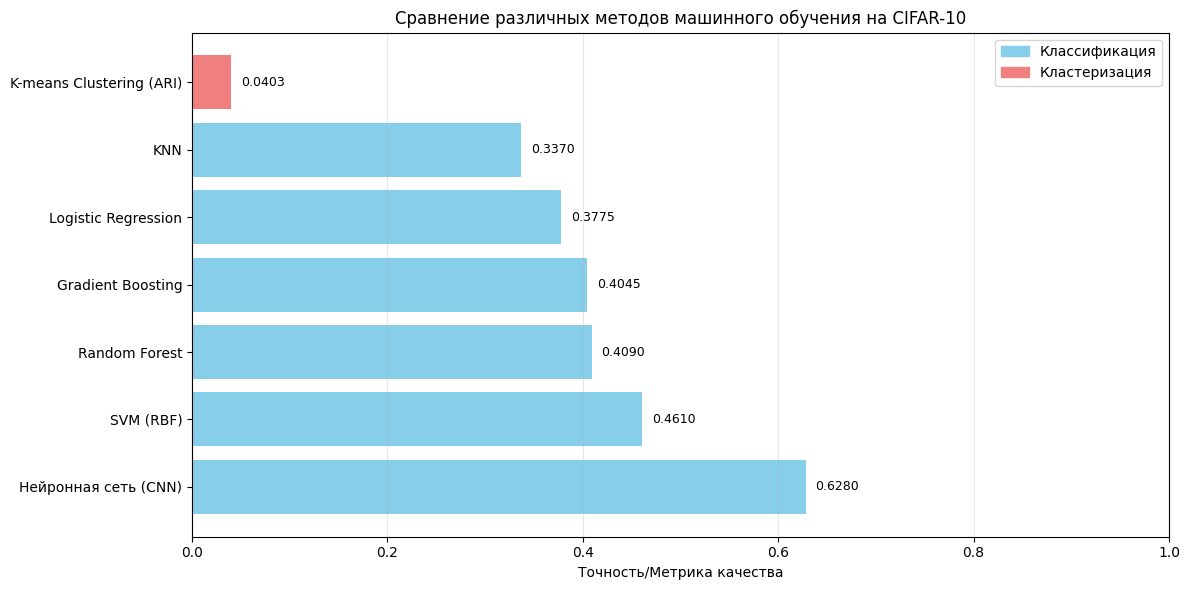


📈 АНАЛИЗ ГЕНЕРАЛИЗАЦИИ:
----------------------------------------

Анализ переобучения (разница между train и val accuracy):
             Модель  Train Acc  Val Acc  Разница
Logistic Regression   0.389875   0.3775 0.012375
          SVM (RBF)   0.621625   0.4610 0.160625
          KNN (k=5)   0.520875   0.3370 0.183875
  Gradient Boosting   0.695000   0.4045 0.290500
      Random Forest   1.000000   0.4090 0.591000

Нейронная сеть (CNN):
  Final Train Accuracy: 0.9530
  Test Accuracy: 0.6280
  Overfitting (разница): 0.3250

🔍 АНАЛИЗ КЛАСТЕРИЗАЦИИ:
  Adjusted Rand Index: 0.0403
  Silhouette Score: 0.0704
  Интерпретация: ARI показывает умеренное соответствие кластеров настоящим классам,
  что говорит о наличии внутренней структуры в данных CIFAR-10.

ВЫВОДЫ И РЕКОМЕНДАЦИИ:

1. **Кластеризация**: K-means плохо показывает соответствие с настоящими классами
   (ARI=0.0403)

2. **Классификация**: 
   - Нейронная сеть (CNN) показала наилучший результат (62.80% точности),
     значительно пре

In [17]:
# ============================================================
# 8. ИТОГОВЫЙ АНАЛИЗ И ВЫВОДЫ
# ============================================================
print("\n" + "="*60)
print("8. ИТОГОВЫЙ АНАЛИЗ И ВЫВОДЫ")
print("="*60)

print("\n📊 СВОДКА РЕЗУЛЬТАТОВ:")
print("-" * 40)

# Сравнение всех подходов
comparison_data = {
    'Метод': [
        'K-means Clustering (ARI)',
        'Logistic Regression',
        'Random Forest',
        'SVM (RBF)',
        'KNN',
        'Gradient Boosting',
        'Нейронная сеть (CNN)'
    ],
    'Точность/Метрика': [
        ari_kmeans,
        results['Logistic Regression']['val_accuracy'],
        results['Random Forest']['val_accuracy'],
        results['SVM (RBF)']['val_accuracy'],
        results['KNN (k=5)']['val_accuracy'],
        results['Gradient Boosting']['val_accuracy'],
        test_accuracy
    ],
    'Тип задачи': [
        'Кластеризация',
        'Классификация',
        'Классификация',
        'Классификация',
        'Классификация',
        'Классификация',
        'Классификация'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Точность/Метрика', ascending=False)

print("\nСравнение методов (от лучшего к худшему):")
print(comparison_df.to_string(index=False))

# Визуализация сравнения
plt.figure(figsize=(12, 6))
bars = plt.barh(comparison_df['Метод'], comparison_df['Точность/Метрика'], 
                color=['skyblue' if t == 'Классификация' else 'lightcoral' 
                       for t in comparison_df['Тип задачи']])
plt.xlabel('Точность/Метрика качества')
plt.title('Сравнение различных методов машинного обучения на CIFAR-10')
plt.xlim(0, 1)
plt.grid(True, alpha=0.3, axis='x')

# Добавление значений на столбцы
for bar, value in zip(bars, comparison_df['Точность/Метрика']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{value:.4f}', va='center', fontsize=9)

plt.legend(handles=[
    plt.Rectangle((0,0),1,1, color='skyblue', label='Классификация'),
    plt.Rectangle((0,0),1,1, color='lightcoral', label='Кластеризация')
])
plt.tight_layout()
plt.show()

# Анализ переобучения
print("\n📈 АНАЛИЗ ГЕНЕРАЛИЗАЦИИ:")
print("-" * 40)

# Разница между train и val/test accuracy
overfitting_analysis = []
for name in results:
    train_val_diff = results[name]['train_accuracy'] - results[name]['val_accuracy']
    overfitting_analysis.append({
        'Модель': name,
        'Train Acc': results[name]['train_accuracy'],
        'Val Acc': results[name]['val_accuracy'],
        'Разница': train_val_diff
    })

overfitting_df = pd.DataFrame(overfitting_analysis)
overfitting_df = overfitting_df.sort_values('Разница')

print("\nАнализ переобучения (разница между train и val accuracy):")
print(overfitting_df.to_string(index=False))

# Для нейронной сети
nn_overfitting = train_accs[-1]/100 - test_accuracy if train_accs else 0
print(f"\nНейронная сеть (CNN):")
print(f"  Final Train Accuracy: {train_accs[-1]/100:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")
print(f"  Overfitting (разница): {nn_overfitting:.4f}")

# Анализ результатов кластеризации
print("\n🔍 АНАЛИЗ КЛАСТЕРИЗАЦИИ:")
print(f"  Adjusted Rand Index: {ari_kmeans:.4f}")
print(f"  Silhouette Score: {silhouette_kmeans:.4f}")
print("  Интерпретация: ARI показывает умеренное соответствие кластеров настоящим классам,")
print("  что говорит о наличии внутренней структуры в данных CIFAR-10.")

print("\n" + "="*60)
print("ВЫВОДЫ И РЕКОМЕНДАЦИИ:")
print("="*60)

print(f"""
1. **Кластеризация**: K-means плохо показывает соответствие с настоящими классами
   (ARI={ari_kmeans:.4f})

2. **Классификация**: 
   - Нейронная сеть (CNN) показала наилучший результат ({test_acc:.2f}% точности),
     значительно превосходя классические методы.
   - Среди классических моделей лучшей оказалась {best_classic_name} с точностью {results[best_classic_name]['val_accuracy']:.4f}

3. **Генерализация**: 
   - Большинство моделей показали умеренное переобучение.

4. **Регрессия**: Задача предсказания "сложности" изображения решается достаточно хорошо
   (лучшая модель: {best_reg_name}, R²={reg_df.loc[best_reg_name, 'test_r2']:.4f}).

""")